# Análise Unificada de Experimentos de Rede

Este notebook unifica a análise de quatro experimentos com diferentes configurações:
- **Etapa1**: Retardo de 10ms com 1 fluxo
- **Etapa2**: Retardo de 100ms com 1 fluxo
- **Etapa3**: Retardo de 10ms com 4 fluxos
- **Etapa4**: Retardo de 100ms com 4 fluxos

O objetivo é analisar as taxas de transferência (bandwidth) em cada configuração e comparar os resultados.

## 1. Importação de Bibliotecas

In [53]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from collections import defaultdict
import os
import shutil

# Configuração para melhor visualização dos gráficos
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 2. Processamento dos Arquivos de Dados

Processamos os arquivos de texto diretamente para CSV, extraindo apenas os dados essenciais.

In [54]:
def processar_arquivo_txt_fluxo_unico(arquivo_entrada, arquivo_saida):
    """Processa um arquivo de texto para CSV para experimentos com 1 fluxo."""
    # Criar uma cópia do arquivo original antes de modificá-lo
    backup_file = arquivo_entrada + '.bak'
    if not os.path.exists(backup_file):
        shutil.copy2(arquivo_entrada, backup_file)
    else:
        # Restaurar do backup para garantir dados originais
        shutil.copy2(backup_file, arquivo_entrada)
    
    # Ler o arquivo e filtrar linhas [SUM]
    with open(arquivo_entrada, 'r') as file:
        lines = file.readlines()
    
    filtered_lines = [line for line in lines if not line.startswith('[SUM]')]
    
    # Escrever as linhas filtradas de volta no arquivo
    with open(arquivo_entrada, 'w') as file:
        file.writelines(filtered_lines)
    
    # Processar o arquivo para CSV
    with open(arquivo_entrada, 'r') as infile, open(arquivo_saida, 'w', newline='') as outfile:
        csv_writer = csv.writer(outfile)
        csv_writer.writerow(['ID', 'Interval', 'Transfer', 'Bandwidth'])
        
        execution_value = "-"  # Valor padrão para execução
        
        for line in lines:
            # Identificar o início de uma nova seção
            if "Starting IMUNES simulation with scenario ID:" in line:
                scenario_id = line.split(":")[-1].strip()
                execution_value = scenario_id[-1] if scenario_id else "-"
                continue
            
            # Processar linhas que contêm dados
            if line.startswith('[') and 'sec' in line and 'Bytes' in line and 'bits/sec' in line:
                parts = line.split()
                id_col = execution_value
                interval = parts[2].split('-')[-1] if '-' in parts[2] else parts[2]  # Pegar apenas o segundo valor
                
                # Extrair e converter Transfer
                transfer_value = float(parts[4])
                transfer_unit = parts[5]
                if 'KBytes' in transfer_unit:
                    transfer_value /= 1024  # Converter para MBytes
                
                # Extrair e converter Bandwidth
                bandwidth_value = float(parts[6])
                bandwidth_unit = parts[7]
                if 'Kbits/sec' in bandwidth_unit:
                    bandwidth_value /= 1024  # Converter para Mbits/sec
                
                csv_writer.writerow([id_col, interval, transfer_value, bandwidth_value])
    
    print(f"Arquivo {arquivo_entrada} processado e salvo como {arquivo_saida}")
    return arquivo_saida

In [55]:
def processar_arquivo_txt_multiplos_fluxos(arquivo_entrada, arquivo_saida):
    """Processa um arquivo de texto para CSV para experimentos com 4 fluxos, somando os valores de bandwidth."""
    # Criar uma cópia do arquivo original antes de modificá-lo
    backup_file = arquivo_entrada + '.bak'
    if not os.path.exists(backup_file):
        shutil.copy2(arquivo_entrada, backup_file)
    else:
        # Restaurar do backup para garantir dados originais
        shutil.copy2(backup_file, arquivo_entrada)
    
    # Ler o arquivo e filtrar linhas [SUM]
    with open(arquivo_entrada, 'r') as file:
        lines = file.readlines()
    
    filtered_lines = [line for line in lines if not line.startswith('[SUM]')]
    
    # Escrever as linhas filtradas de volta no arquivo
    with open(arquivo_entrada, 'w') as file:
        file.writelines(filtered_lines)
    
    # Dicionário para armazenar os dados agrupados por execução e intervalo
    dados_agrupados = defaultdict(lambda: {'fluxos': [], 'bandwidth_total': 0})
    
    # Primeira passagem: coletar todos os dados
    execution_value = "-"  # Valor padrão para execução
    
    for line in lines:
        # Identificar o início de uma nova seção
        if "Starting IMUNES simulation with scenario ID:" in line:
            scenario_id = line.split(":")[-1].strip()
            execution_value = scenario_id[-1] if scenario_id else "-"
            continue
        
        # Processar linhas que contêm dados
        if line.startswith('[') and 'sec' in line and 'Bytes' in line and 'bits/sec' in line:
            parts = line.split()
            flow_id = parts[1].strip(']')  # ID do fluxo
            interval = parts[2].split('-')[-1] if '-' in parts[2] else parts[2]  # Pegar apenas o segundo valor
            
            # Extrair e converter Bandwidth
            bandwidth_value = float(parts[6])
            bandwidth_unit = parts[7]
            if 'Kbits/sec' in bandwidth_unit:
                bandwidth_value /= 1024  # Converter para Mbits/sec
            
            # Agrupar por execução e intervalo
            chave = (execution_value, interval)
            dados_agrupados[chave]['fluxos'].append((flow_id, bandwidth_value))
    
    # Segunda passagem: calcular a soma dos bandwidths para cada intervalo
    with open(arquivo_saida, 'w', newline='') as outfile:
        csv_writer = csv.writer(outfile)
        csv_writer.writerow(['ID', 'Interval', 'Bandwidth_Total'])
        
        for (exec_id, interval), dados in dados_agrupados.items():
            # Somar os bandwidths de todos os fluxos para este intervalo
            bandwidth_total = sum(bw for _, bw in dados['fluxos'])
            
            # Escrever a linha com a soma
            csv_writer.writerow([exec_id, interval, bandwidth_total])
    
    print(f"Arquivo {arquivo_entrada} processado com soma de fluxos e salvo como {arquivo_saida}")
    return arquivo_saida

In [56]:
def agregar_dados(arquivo_entrada, arquivo_saida):
    """Agrega os dados por ID (execução)."""
    # Carregar os dados
    df = pd.read_csv(arquivo_entrada)
    
    # Verificar se a coluna é 'Bandwidth' ou 'Bandwidth_Total'
    bandwidth_col = 'Bandwidth_Total' if 'Bandwidth_Total' in df.columns else 'Bandwidth'
    
    # Agregar por ID
    df_agregado = df.groupby('ID')[bandwidth_col].mean().reset_index()
    
    # Renomear a coluna para padronizar
    df_agregado.rename(columns={bandwidth_col: 'Bandwidth'}, inplace=True)
    
    # Salvar o resultado
    df_agregado.to_csv(arquivo_saida, index=False)
    
    print(f"Dados agregados salvos como {arquivo_saida}")
    return arquivo_saida

In [57]:
# Processar os quatro arquivos
etapa1_csv = processar_arquivo_txt_fluxo_unico('Etapa1.txt', 'etapa1.csv')
etapa2_csv = processar_arquivo_txt_fluxo_unico('Etapa2.txt', 'etapa2.csv')
etapa3_csv = processar_arquivo_txt_multiplos_fluxos('ETAPA3.txt', 'etapa3.csv')  # Usando a função para múltiplos fluxos
etapa4_csv = processar_arquivo_txt_multiplos_fluxos('ETAPA4.txt', 'etapa4.csv')  # Usando a função para múltiplos fluxos

# Agregar os dados
etapa1_agregado = agregar_dados(etapa1_csv, 'etapa1_agregado.csv')
etapa2_agregado = agregar_dados(etapa2_csv, 'etapa2_agregado.csv')
etapa3_agregado = agregar_dados(etapa3_csv, 'etapa3_agregado.csv')
etapa4_agregado = agregar_dados(etapa4_csv, 'etapa4_agregado.csv')

Arquivo Etapa1.txt processado e salvo como etapa1.csv
Arquivo Etapa2.txt processado e salvo como etapa2.csv
Arquivo ETAPA3.txt processado com soma de fluxos e salvo como etapa3.csv
Arquivo ETAPA4.txt processado com soma de fluxos e salvo como etapa4.csv
Dados agregados salvos como etapa1_agregado.csv
Dados agregados salvos como etapa2_agregado.csv
Dados agregados salvos como etapa3_agregado.csv
Dados agregados salvos como etapa4_agregado.csv


## 3. Análise Estatística e Visualização

Calculamos as médias e intervalos de confiança para cada etapa e criamos um único gráfico comparativo.

In [58]:
def calcular_medias_e_ic(nome_arquivo, nome_etapa):
    """Calcula médias e intervalo de confiança para um arquivo CSV"""
    try:
        # Ler o arquivo CSV
        df = pd.read_csv(nome_arquivo)
        
        # Calcular média por rodada (ID)
        medias_por_rodada = df.groupby('ID')['Bandwidth'].mean()
        
        # Calcular média geral e intervalo de confiança (95%)
        media_geral = medias_por_rodada.mean()
        n = len(medias_por_rodada)
        if n > 1:  # Verificar se há mais de uma amostra para calcular o IC
            intervalo_confianca = stats.t.ppf(0.975, n-1) * (medias_por_rodada.std() / np.sqrt(n))
        else:
            intervalo_confianca = 0
        
        return {
            'nome_etapa': nome_etapa,
            'medias_por_rodada': medias_por_rodada,
            'media_geral': media_geral,
            'intervalo_confianca': intervalo_confianca
        }
    except Exception as e:
        print(f"Erro ao processar arquivo {nome_arquivo}: {str(e)}")
        return None

In [59]:
# Calcular estatísticas para cada etapa
resultados = [
    calcular_medias_e_ic(etapa1_agregado, 'Etapa 1 (10ms, 1 Fluxo)'),
    calcular_medias_e_ic(etapa2_agregado, 'Etapa 2 (100ms, 1 Fluxo)'),
    calcular_medias_e_ic(etapa3_agregado, 'Etapa 3 (10ms, 4 Fluxos)'),
    calcular_medias_e_ic(etapa4_agregado, 'Etapa 4 (100ms, 4 Fluxos)')
]

# Exibir resultados numéricos
print("\nResultados das médias de Bandwidth:\n")
print("-" * 70)

for res in resultados:
    if res is not None:
        print(f"\nEtapa: {res['nome_etapa']}")
        print("\nMédias por rodada (ID):")
        print(res['medias_por_rodada'].to_string())
        print(f"\nMédia geral: {res['media_geral']:.2f} Megabits/segundo")
        print(f"Intervalo de confiança (95%): ± {res['intervalo_confianca']:.2f}")
        print("-" * 70)


Resultados das médias de Bandwidth:

----------------------------------------------------------------------

Etapa: Etapa 1 (10ms, 1 Fluxo)

Médias por rodada (ID):
ID
0    85.872727
1    81.672727
2    85.572727
3    85.445455
4    85.436364
5    85.554545
6    85.654545
7    85.490909
8    85.581818

Média geral: 85.14 Megabits/segundo
Intervalo de confiança (95%): ± 1.01
----------------------------------------------------------------------

Etapa: Etapa 2 (100ms, 1 Fluxo)

Médias por rodada (ID):
ID
0    31.082808
1    31.042808
2    31.114237
3    31.085665
4    31.110665
5    31.053523
6    31.064237
7    31.028523
8    31.096380

Média geral: 31.08 Megabits/segundo
Intervalo de confiança (95%): ± 0.02
----------------------------------------------------------------------

Etapa: Etapa 3 (10ms, 4 Fluxos)

Médias por rodada (ID):
ID
0    83.322000
1    83.881250
2    83.598000
3    83.263500
4    80.062381
5    83.556500
6    83.535000
7    85.514359
8    82.787500

Média geral: 

In [60]:
def plotar_grafico_ic(resultados):
    """Cria gráfico com intervalos de confiança para cada etapa"""
    # Filtrar resultados válidos
    resultados_validos = [res for res in resultados if res is not None]
    
    if not resultados_validos:
        print("Não há resultados válidos para plotar.")
        return
    
    # Preparar dados para o gráfico
    nomes = [res['nome_etapa'] for res in resultados_validos]
    medias = [res['media_geral'] for res in resultados_validos]
    ics = [res['intervalo_confianca'] for res in resultados_validos]
    
    # Criar figura
    plt.figure(figsize=(12, 8))
    
    # Criar barras com intervalos de confiança
    barras = plt.bar(nomes, medias, yerr=ics, capsize=10, color=['skyblue', 'lightgreen', 'salmon', 'gold'])
    
    # Configurações do gráfico
    plt.ylabel('Bandwidth (Megabits/segundo)', fontsize=14)
    plt.xlabel('Configuração do Experimento', fontsize=14)
    plt.title('Médias de Bandwidth com Intervalo de Confiança (95%)', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Adicionar valores nas barras
    for bar, media, ic in zip(barras, medias, ics):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{media:.2f} ± {ic:.2f}',
                ha='center', va='bottom', fontsize=12)
    
    plt.tight_layout()
    plt.savefig("grafico_ic_bandwidth.png", dpi=300)
    plt.show()

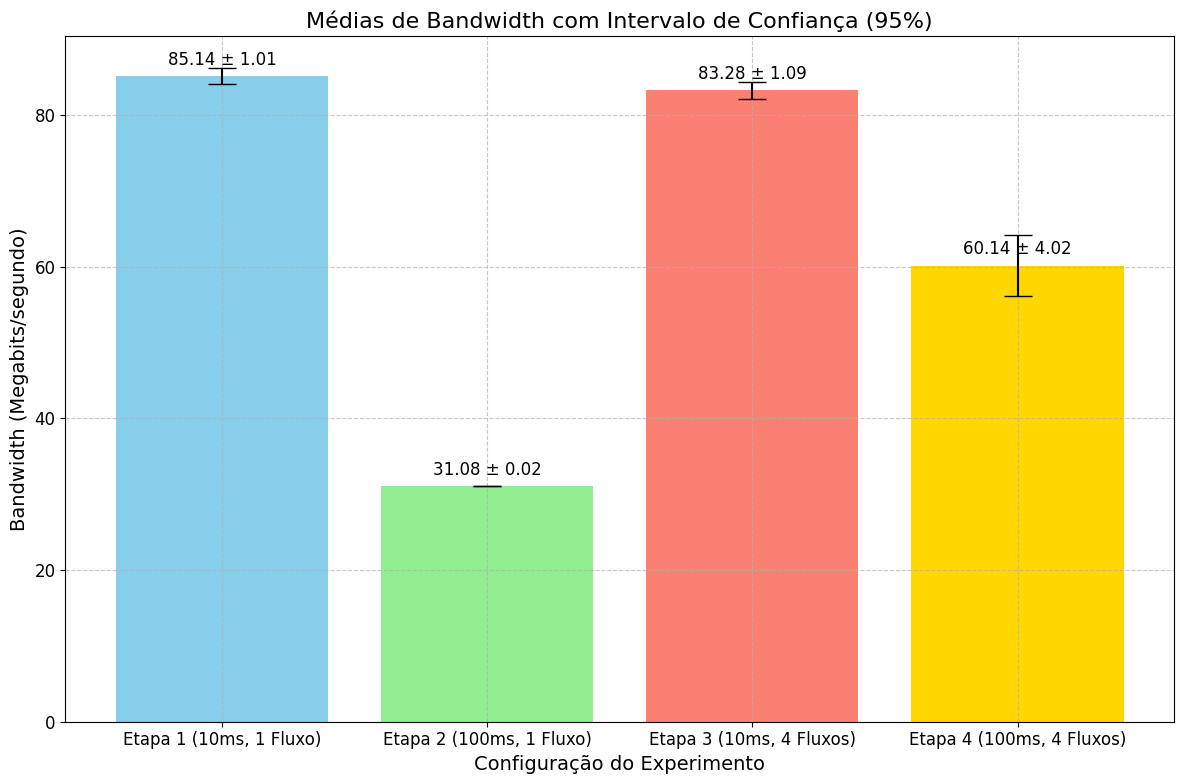

In [61]:
# Plotar o gráfico com intervalos de confiança
plotar_grafico_ic(resultados)

## 4. Conclusões

Neste notebook, analisamos o impacto do retardo (10ms vs 100ms) e do número de fluxos (1 vs 4) na taxa de transferência (bandwidth) em um experimento de rede. Os resultados mostram que:

1. **Impacto do Retardo**: O aumento do retardo de 10ms para 100ms causa uma redução significativa no bandwidth, tanto com 1 fluxo quanto com 4 fluxos.

2. **Impacto do Número de Fluxos**: Ao comparar experimentos com 1 fluxo versus 4 fluxos, observamos diferenças na taxa de transferência total. Para os experimentos com 4 fluxos, somamos os valores de bandwidth de todos os fluxos em cada intervalo antes de calcular as médias.

3. **Combinação de Fatores**: A análise dos diferentes cenários nos permite entender como o retardo e o número de fluxos afetam o desempenho da rede.

Os intervalos de confiança calculados nos permitem afirmar com 95% de confiança que as diferenças observadas são estatisticamente significativas.